In [1]:
import pandas as pd

import numpy as np
np.random.seed(0)

import seaborn as sns; 
sns.set_theme()

import matplotlib.pyplot as plt
from matplotlib import pyplot

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import pickle
import requests
import json
import urllib.request
import time
import re
import itertools
import statistics
import random

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from typing import List, Dict, Tuple, Set
from bs4 import BeautifulSoup

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.datasets import make_classification

from datetime import datetime
from scipy.stats import skew

from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import Constant
from keras.layers.preprocessing.text_vectorization import TextVectorization
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import tensorflow.keras.utils as kutils
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks

from collections import Counter
from imblearn.over_sampling import RandomOverSampler 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_firefox_df = pd.read_csv('../../PreProcessedData/Firefox/Firefox_siamese_train_preprocessed.csv')

print('Dimensions of Training Dataset: ', train_firefox_df.shape)

#To show Data
train_firefox_df.head()

Dimensions of Training Dataset:  (31611, 4)


,Unnamed: 0,description1,description2,is_similar
0,0,created attachment fandango com after sign...,user agent mozilla gecko firefox ...,0
1,1,created attachment dropdown marker ...,user agent mozilla gecko firefox ...,1
2,3,this bug was initially created as a clon...,note i am very bad at filing bugs so i apo...,0
3,4,currently in policies we have two function ...,filed by ncsoregi at mozilla com pa...,0
4,5,remove bottom margin on image wrapper for ...,there s only a few tests remaining in browse...,0


In [3]:
test_firefox_df = pd.read_csv('../../PreProcessedData/Firefox/Firefox_siamese_test_preprocessed.csv')

print('Dimensions of Testing Dataset: ', test_firefox_df.shape)

#To show Data
test_firefox_df.head()

Dimensions of Testing Dataset:  (8167, 4)


,Unnamed: 0,description1,description2,is_similar
0,0,the comment in the code suggests it can be r...,bug is adding a new pinned page action o...,0
1,1,created attachment jira sidbar png user a...,automatically unloading a webrtc tab seems l...,0
2,2,created attachment reference png hi th...,filed by philringnalda at gmail com j...,0
3,3,markdown filed by rmaries at mozilla ...,user agent mozilla gecko firefox ...,0
4,4,user agent mozilla gecko firefox ...,currently we are storing full details in t...,0


In [4]:
#Concatenate Train and Test Data
result = pd.concat([train_firefox_df, test_firefox_df])
result = result.sample(frac=1, random_state=1).reset_index(drop=True)

dup_df= result.copy()

In [5]:
description = ['description1', 'description2']

#To Describe Length of 'Description' of the Bugs
dup_df[description].apply(lambda col: col.str.len().describe())

,description1,description2
count,39778.000000,39778.000000
mean,1111.995324,1185.271406
std,2859.586179,3082.720871
min,50.000000,50.000000
25%,281.000000,289.000000
50%,482.000000,510.000000
75%,841.000000,925.000000
max,67448.000000,67448.000000


# Splitting Data into Train, Test and Validation

In [6]:
train_val_df = train_firefox_df.copy()
test_df = test_firefox_df.copy()

In [7]:
train_df, val_df = train_test_split(train_val_df, test_size = 0.2, stratify = train_val_df.is_similar, random_state = 13)

In [8]:
print('Size of Training Dataset: ', train_df.shape[0])
print('Size of Validation Dataset: ', val_df.shape[0])
print('Size of Testing Dataset: ', test_df.shape[0])

Size of Training Dataset:  25288
Size of Validation Dataset:  6323
Size of Testing Dataset:  8167


In [9]:
len(val_df[val_df.is_similar.astype('bool')]) / len(val_df)

0.19136485845326587

In [10]:
sm = RandomOverSampler(random_state=42)
X_res, y_res = sm.fit_resample(X=train_df[['description1', 'description2']], y=train_df.is_similar)

In [11]:
train_df = X_res.copy()
train_df['is_similar'] = y_res
train_df = train_df.sample(frac=1)

In [12]:
len(train_df[train_df.is_similar.astype('bool')]) / len(train_df)

0.5

# Create Vocabulary Index

In [13]:
MAX_TOKENS = 20000
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 500
EMBEDDING_DIM = 100

In [14]:
def build_vocab(sentences: List[str], sequence_length: int):
    vectorizer = TextVectorization(max_tokens=MAX_TOKENS - 2,output_sequence_length=sequence_length)
    vectorizer.adapt(sentences)
    vocab = vectorizer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))

    return vectorizer, word_index

In [15]:
descr_vectorizer, descr_word_index = build_vocab([dup_df.description1, dup_df.description2],MAX_DESCRIPTION_LENGTH)

print(  'Most frequent description words:',list(itertools.islice(descr_word_index.keys(), 5)))

Most frequent description words: ['', '[UNK]', 'info', 'the', 'task']


# To Prepare Training Data

In [16]:
def generate_batches(split_df: pd.DataFrame,batch_size=256):
    steps_per_epoch = len(split_df) // batch_size
    while True:
        for i in range(steps_per_epoch):
            offset = i * batch_size
            till = offset + batch_size
            feature_batches = []
            for feature in description:
                vectorizer = descr_vectorizer
                feature_batch = vectorizer(split_df[feature][offset: till].to_numpy().reshape((-1, 1))).numpy()
                feature_batches.append(feature_batch)
                
            target_batch = split_df.is_similar[offset: till].to_numpy()
            yield (feature_batches,target_batch)

In [17]:
DescrEmbeddingLayer = layers.Embedding(input_dim=MAX_TOKENS,output_dim=EMBEDDING_DIM,name='DescrEmbeddingLayer')

def make_descr_layer(num, kernel_size=3, pool_size=2, strides=None):
    DescrConv1dLayer = layers.Conv1D(filters=32,kernel_size=kernel_size,activation='relu',name=f'DescrConv1dLayer{num}')
    DescrMaxPool1dLayer = layers.MaxPool1D(pool_size=pool_size,strides=strides,name=f'DescrMaxPool1dLayer{num}')
    return DescrConv1dLayer, DescrMaxPool1dLayer

DescrConv1dLayer1, DescrMaxPool1dLayer1 = make_descr_layer(1, pool_size=4)
DescrConv1dLayer2, DescrMaxPool1dLayer2 = make_descr_layer(2)

In [18]:
def create_siamese_component(num: int):
    class SiameseComponent:
        def __init__(self, title: layers.Input, description: layers.Input, output: layers.Concatenate):
            self.title = title
            self.description = description
            self.output = output

    title_input = layers.Input(shape=(None,), dtype='int32', name=f'title{num}_input')

    descr_input = layers.Input(shape=(None,), name=f'descr{num}_input')
    descr_embedding_layer = DescrEmbeddingLayer(descr_input)
    descr_conv1d1 = DescrConv1dLayer1(descr_embedding_layer)
    descr_max_pool1d1 = DescrMaxPool1dLayer1(descr_conv1d1)
    descr_conv1d2 = DescrConv1dLayer2(descr_max_pool1d1)
    descr_max_pool1d2 = DescrMaxPool1dLayer2(descr_conv1d2)
    descr_flat_Layer = layers.Flatten(name=f'FlatDescr{num}')(descr_max_pool1d2)

    concat = layers.Concatenate(axis=1, name=f'Concat{num}')([descr_flat_Layer])
    return SiameseComponent(title_input, descr_input, concat)

component1 = create_siamese_component(1)
component2 = create_siamese_component(2)

dot_product_layer = layers.Dot(axes=1,name='dot_product_layer')([component1.output, component2.output])

output = layers.Dense(1, activation='sigmoid', name='output')(dot_product_layer)

siamese_model = models.Model(inputs=[component1.description, component2.description],outputs=output,name='siamese_model')

kutils.plot_model(siamese_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train

In [19]:
BATCH_SIZE = 256
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

siamese_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

history = siamese_model.fit(
  generate_batches(train_df, BATCH_SIZE),
  steps_per_epoch=len(train_df) // BATCH_SIZE,
  epochs=12,
  validation_data=generate_batches(val_df, BATCH_SIZE),
  validation_steps=len(val_df) // BATCH_SIZE,
  verbose=1
)

Epoch 1/12
159/159 [==============================] - 68s 420ms/step - loss: 0.6131 - acc: 0.6620 - val_loss: 0.7105 - val_acc: 0.6823
Epoch 2/12
159/159 [==============================] - 61s 384ms/step - loss: 0.4907 - acc: 0.8144 - val_loss: 0.6773 - val_acc: 0.7624
Epoch 3/12
159/159 [==============================] - 67s 419ms/step - loss: 0.3932 - acc: 0.8795 - val_loss: 0.6476 - val_acc: 0.7996
Epoch 4/12
159/159 [==============================] - 70s 439ms/step - loss: 0.3174 - acc: 0.9216 - val_loss: 0.6480 - val_acc: 0.8083
Epoch 5/12
159/159 [==============================] - 64s 401ms/step - loss: 0.2653 - acc: 0.9472 - val_loss: 0.6896 - val_acc: 0.8084
Epoch 6/12
159/159 [==============================] - 75s 470ms/step - loss: 0.2283 - acc: 0.9597 - val_loss: 0.7225 - val_acc: 0.8114
Epoch 7/12
159/159 [==============================] - 75s 472ms/step - loss: 0.2010 - acc: 0.9673 - val_loss: 0.6636 - val_acc: 0.8241
Epoch 8/12
159/159 [==============================] - 7

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


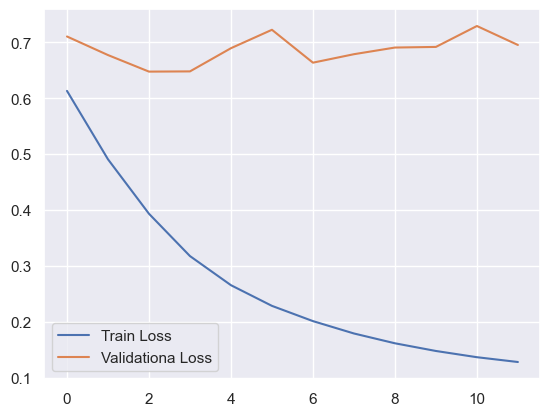

In [20]:
plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#To Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validationa Loss')
plt.legend()
plt.show()

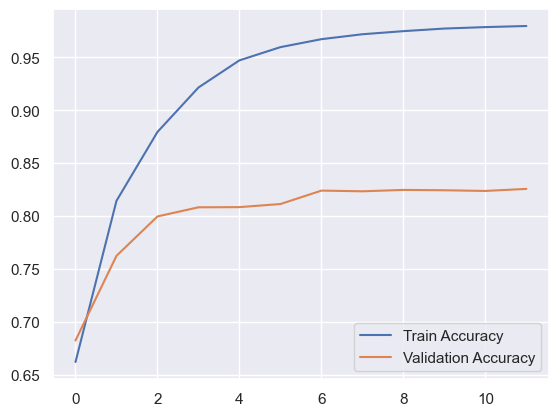

In [21]:
#To Plot Accuracy
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()

In [22]:
siamese_model.evaluate(generate_batches(test_df, BATCH_SIZE),steps=len(test_df) // BATCH_SIZE)

BATCH_SIZE = len(test_df)

num_batched_instances = len(test_df) - (len(test_df) % BATCH_SIZE)

pred_y = siamese_model.predict(generate_batches(test_df, BATCH_SIZE),steps=len(test_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 5s 5s/step


In [23]:
print('AUC:', roc_auc_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('Recall:', recall_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('Precision:', precision_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('F1:', f1_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))      

AUC: 0.6535397009798248
Recall: 0.7862128076405045
Precision: 0.7936415310829948
F1: 0.7897197018822073


In [24]:
#Classification Report
print(classification_report(test_df.is_similar[:num_batched_instances], pred_y > .5,))

print('\nAUC:', roc_auc_score(test_df.is_similar[:num_batched_instances], pred_y > .5))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6706
           1       0.41      0.45      0.43      1461

    accuracy                           0.79      8167
   macro avg       0.64      0.65      0.65      8167
weighted avg       0.79      0.79      0.79      8167


AUC: 0.6535397009798248


In [25]:
value_names = ['TPR', 'FPR', 'Threshold']

roc = dict(zip(value_names, roc_curve(test_df.is_similar[:num_batched_instances],pred_y)))

pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,2.000000
1,0.011035,0.086242,1.000000
2,0.011780,0.086927,1.000000
3,0.012973,0.092402,1.000000
4,0.013272,0.094456,1.000000
...,...,...,...
1424,0.448106,0.783025,0.157295
1425,0.449597,0.783025,0.157291
1426,0.449597,0.783710,0.157291
1427,0.449896,0.783710,0.157291


# To Evaluate Textually Similar Data

In [26]:
sim_df_original = pd.read_csv('../../PreProcessedData/Firefox/Firefox_textually_similar_pair.csv')

print('Dimensions of Dataset: ', sim_df_original.shape)

Dimensions of Dataset:  (536, 9)


In [27]:
#Preprocessing Dataset
sim_df = pd.DataFrame()

sim_df['Unnamed: 0'] = sim_df_original['Unnamed: 0']
sim_df['description1'] = sim_df_original['Description1']
sim_df['description2'] = sim_df_original['Description2']
sim_df['is_similar'] = sim_df_original['is_similar']

sim_df['description1'] = sim_df['description1'].str.replace('[','').str.replace(']','')
sim_df['description2'] = sim_df['description2'].str.replace('[','').str.replace(']','')

sim_df['description1'] = sim_df['description1'].str.replace("'", "")
sim_df['description2'] = sim_df['description2'].str.replace("'", "")

#To show Data
sim_df.head()

,Unnamed: 0,description1,description2,is_similar
0,0,created attachment keyselectedsearch mozi...,i noticed this while working on bug and i t...,1
1,4,created attachment bug dialog png user agen...,created attachment screenshot of bookmark wi...,1
2,8,created attachment firefoxfail png user age...,created attachment toolbar screenshot png s...,1
3,11,created attachment screenshot png user agen...,str open open another tab in th...,1
4,12,user agent mozilla gecko firefox ...,based on edit the overlay icon should ch...,1


In [28]:
#Adding Data to the Dataframe
sim_df_new = sim_df[['description1', 'description2', 'is_similar']]
sim_df_new['description2'] = sim_df_new.description2.shift(1)
sim_df_new['is_similar'] = 0
sim_df_new.dropna(inplace = True)
sim_df = pd.concat([sim_df[['description1', 'description2', 'is_similar']],sim_df_new])

In [29]:
BATCH_SIZE = len(sim_df)

siamese_model.evaluate(generate_batches(sim_df, BATCH_SIZE),steps=len(sim_df) // BATCH_SIZE)

num_batched_instances = len(sim_df) - (len(sim_df) % BATCH_SIZE)

pred_y_sim = siamese_model.predict(generate_batches(sim_df, BATCH_SIZE),steps=len(sim_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 1s 607ms/step


In [30]:
print('AUC:', roc_auc_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('Recall:', recall_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('Precision:', precision_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('F1:', f1_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))  

AUC: 0.5656454875156927
Recall: 0.5658263305322129
Precision: 0.577215784386827
F1: 0.5488901364344875


In [31]:
#Classification Report
print(classification_report(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5,))

print('\nAUC:', roc_auc_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5))

              precision    recall  f1-score   support

           0       0.61      0.37      0.46       535
           1       0.55      0.76      0.64       536

    accuracy                           0.57      1071
   macro avg       0.58      0.57      0.55      1071
weighted avg       0.58      0.57      0.55      1071


AUC: 0.5656454875156927


# To Evaluate Textually Dissimilar Data

In [32]:
dissim_df_original = pd.read_csv('../../PreProcessedData/Firefox/Firefox_textually_dissimilar_pair.csv')

print('Dimensions of Dataset: ', dissim_df_original.shape)

Dimensions of Dataset:  (816, 9)


In [33]:
#Preprocessing Dataset
dissim_df = pd.DataFrame()

dissim_df['Unnamed: 0'] = dissim_df_original['Unnamed: 0']
dissim_df['description1'] = dissim_df_original['Description1']
dissim_df['description2'] = dissim_df_original['Description2']
dissim_df['is_similar'] = dissim_df_original['is_similar']

#df['my_column'] = df['my_column'].str.replace('[','').str.replace(']','')
dissim_df['description1'] = dissim_df['description1'].str.replace('[','').str.replace(']','')
dissim_df['description2'] = dissim_df['description2'].str.replace('[','').str.replace(']','')

#df['my_column'] = df['my_column'].str.replace("'", "")
dissim_df['description1'] = dissim_df['description1'].str.replace("'", "")
dissim_df['description2'] = dissim_df['description2'].str.replace("'", "")

#To show Data
dissim_df.head()

,Unnamed: 0,description1,description2,is_similar
0,0,should add the customize firefox tour in the o...,should add the add on tour in the onboarding o...,1
1,1,nightly on windows at the moment a...,this bug was initially created as a clone ...,1
2,2,should not display the notification for the co...,should show the notification bar to notify use...,1
3,3,should highlight the customize button in the h...,should add the add on tour in the onboarding o...,1
4,6,created attachment jiggle video attached ...,created attachment autocomplete richlistbox ...,1


In [34]:
#Adding Data to the Dataframe
dissim_df_new = dissim_df[['description1', 'description2', 'is_similar']]
dissim_df_new['description2'] = dissim_df_new.description2.shift(1)
dissim_df_new['is_similar'] = 0
dissim_df_new.dropna(inplace = True)
dissim_df = pd.concat([sim_df[['description1', 'description2', 'is_similar']],dissim_df_new])

In [35]:
BATCH_SIZE = len(dissim_df)

siamese_model.evaluate(generate_batches(dissim_df, BATCH_SIZE), steps=len(dissim_df) // BATCH_SIZE)

num_batched_instances = len(dissim_df) - (len(dissim_df) % BATCH_SIZE)

pred_y_dis = siamese_model.predict(generate_batches(dissim_df, BATCH_SIZE),steps=len(dissim_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 1s 923ms/step


In [36]:
print('AUC:', roc_auc_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('Recall:', recall_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('Precision:', precision_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('F1:', f1_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))  

AUC: 0.6652197346600333
Recall: 0.6246023329798516
Precision: 0.7305140471371201
F1: 0.642558279207885


In [37]:
#Classification Report
print(classification_report(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5,))

print('\nAUC:', roc_auc_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5))

              precision    recall  f1-score   support

           0       0.86      0.57      0.69      1350
           1       0.41      0.76      0.53       536

    accuracy                           0.62      1886
   macro avg       0.63      0.67      0.61      1886
weighted avg       0.73      0.62      0.64      1886


AUC: 0.6652197346600333
